# Portfolio Project on Biodiversity in National Parks

## Introduction

The purpose of this notebook is to use data exploration, visualisation and inference techniques to gain understanding of the following datasets. <br>
<br>
species_info.csv - contains data about different species and their conservation status. <br>
observations.csv - holds recorded sightings of different species at several national parks for the past 7 days.

This notebook will answer the following research questions. <br>
<br>
What is the distribution of conservation statuses? <br>
Are certain types of species more likely to be endangered? <br>
Which species were spotted the most at each park?

## Understanding the Data

First we will import the relevant libraries.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Matplotlib is building the font cache; this may take a moment.


We will load the datasets into pandas dataframes then read the first 5 rows of each dataframe and perform some summary statistics to gain understanding of the contents of each dataframe.

In [2]:
print('Species Info')
species = pd.read_csv('species_info.csv')
print(species.head(5))
print('')
print('Observations')
observations = pd.read_csv('observations.csv')
print(observations.head(5))

Species Info
  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  
0                           Gapper's Red-Backed Vole                 NaN  
1                              American Bison, Bison                 NaN  
2  Aurochs, Aurochs, Domestic Cattle (Feral), Dom...                 NaN  
3  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)                 NaN  
4                                      Wapiti Or Elk                 NaN  

Observations
            scientific_name                            park_name  observations
0        Vicia benghalensis  Great Smoky Mountains National Park            68
1            Neovison vison  Great Smoky Mountains National Park            77
2         Prunu

From observing the first 5 rows of each dataframe, we see that the dataset Species Info has column names _category, scientific_name, common_names_ and _conservation_status_. The dataset Observations has column names _scientific_name, park_name_ and _observations_. <br>

We have also learnt that _conservation_status_ has missing values.

## Preparing the Data

It makes sense to merge these tables on the common variable _scientific_name_ so that insights can be more easily visualised across the two tables. <br>

However before we can do this, we must first deal with any missing values in each dataframe since merge will fill in any column without matching data as NaN, and check for duplicates of _scientific_name_ in _species_ which will cause more duplicates if unremoved before a merge.

In [3]:
print('Null Values in Species Info')
print(species.isna().sum())
print('\nNull Values in Observations')
print(observations.isna().sum())

Null Values in Species Info
category                  0
scientific_name           0
common_names              0
conservation_status    5633
dtype: int64

Null Values in Observations
scientific_name    0
park_name          0
observations       0
dtype: int64


We have found out that only _conservation_status_ contains null values.

In [4]:
species.conservation_status.value_counts()

conservation_status
Species of Concern    161
Endangered             16
Threatened             10
In Recovery             4
Name: count, dtype: int64

By getting more information about the counts of different values of _conservation_status_, we see that the status is either _Species of Concern, Endangered, Threatened,_ or _In Recovery_. <br>
We can use this context to infer that the _NaN_ values represent species without a conservation status. <br>
Therefore this is structurally missing data. <br>
We can navigate this by filling any _NaN_ values for _conservation_status_ with a new value 'No Conservation Status'.

In [5]:
species['conservation_status'] = species['conservation_status'].fillna('No Conservation Status')

In [6]:
print(species.head(5))

  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names     conservation_status  
0                           Gapper's Red-Backed Vole  No Conservation Status  
1                              American Bison, Bison  No Conservation Status  
2  Aurochs, Aurochs, Domestic Cattle (Feral), Dom...  No Conservation Status  
3  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)  No Conservation Status  
4                                      Wapiti Or Elk  No Conservation Status  


Now that we have dealt with all missing values, we just need to investigate for duplicates in _scientific_name_ in the _species_ dataframe before we merge.

In [7]:
print('Species Unique Values')
print(species.nunique())
print('\nShape of Species Dataframe')
print(species.shape)

Species Unique Values
category                  7
scientific_name        5541
common_names           5504
conservation_status       5
dtype: int64

Shape of Species Dataframe
(5824, 4)


We see that _species_ has 5,824 rows but only 5,541 unique species according to _scientific_name_, so there are duplicates present in this column. <br>

To solve this we will group rows by _scientific_name_ in the species table. If duplicates are caused by differences in _common_names_ we will aggregate these into a list of distinct common names.  <br>

If duplicates are caused by differences in _conservation_status_ we will choose the worst case scenario to ensure that the danger to the species is not understated. <br>
To do this we will make _conservation_status_ an ordinal categorical variable.

In [8]:
status_order = [
    'No Conservation Status',
    'Species of Concern',
    'Threatened',
    'Endangered',
    'In Recovery'
]

In [9]:
species['conservation_status'] = pd.Categorical(
    species['conservation_status'],
    categories=status_order,
    ordered=True
)

In [10]:
species = species.groupby('scientific_name').agg({
    'common_names': lambda x: ', '.join(sorted(set(x))),
    'category': 'first',                # take first value (assuming it's the same across duplicates)
    'conservation_status': 'last'      # take the last value which should be the worst case scenario 
}).reset_index()

print(species.shape)

(5541, 4)


Finally we can see that species now has the same number of rows as distinct scientific names. We can now merge the two tables. <br>

Since the variable of most interest is _observations_ followed by _conservation_status_, we will merge the _species_ dataframe onto the _observations_ dataframe so that the rows of the new dataframe will be all rows from the _observations_ dataframe, with the _species_ info data (which includes _conservation_status_) added on where _scientific_name_ matches. <br>

In [11]:
df = pd.merge(left=species, right=observations, on='scientific_name', how='right')
print('Shape of Observations Dataframe')
print(observations.shape)
print('\nShape of New Dataframe Df')
print(df.shape)

Shape of Observations Dataframe
(23296, 3)

Shape of New Dataframe Df
(23296, 6)


The new dataframe _df_ has the same number of rows as _observations_ but three extra columns as expected. <br>

In [12]:
print(df.isna().sum())

scientific_name        0
common_names           0
category               0
conservation_status    0
park_name              0
observations           0
dtype: int64


The new dataframe has no null values so every scientific name in _observations_ has been matched to a scientific name in _species_.

## Exploratory Data Analysis

Now that we have a combined dataset we will explore the dataset using summary statistics.

In [13]:
df.nunique()

scientific_name        5541
common_names           5237
category                  7
conservation_status       5
park_name                 4
observations            304
dtype: int64

A count of unique values reveals that our dataframe describes 5,540 distinct species which fall into 7 categories and have been observed across 4 different national parks.

In [14]:
print('Categories')
print(df['category'].unique())
print('')
print('Parks')
print(df['park_name'].unique())

Categories
['Vascular Plant' 'Mammal' 'Bird' 'Nonvascular Plant' 'Amphibian'
 'Reptile' 'Fish']

Parks
['Great Smoky Mountains National Park' 'Yosemite National Park'
 'Bryce National Park' 'Yellowstone National Park']


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23296 entries, 0 to 23295
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   scientific_name      23296 non-null  object  
 1   common_names         23296 non-null  object  
 2   category             23296 non-null  object  
 3   conservation_status  23296 non-null  category
 4   park_name            23296 non-null  object  
 5   observations         23296 non-null  int64   
dtypes: category(1), int64(1), object(4)
memory usage: 568.9+ KB


We see that the combined dataframe has 23,296 rows. All variables have the datatype _object_ which is expected for strings, except _conservation_status_ which we made categorical and _observations_ which has datatype _int64_ as expected for a counting variable. <br>

In [16]:
df.describe(include='all')

,scientific_name,common_names,category,conservation_status,park_name,observations
count,23296,23296,23296,23296,23296,23296.000000
unique,5541,5237,7,5,4,NaN
top,Myotis lucifugus,Brachythecium Moss,Vascular Plant,No Conservation Status,Great Smoky Mountains National Park,NaN
freq,12,28,17880,22528,5824,NaN
mean,NaN,NaN,NaN,NaN,NaN,142.287904
std,NaN,NaN,NaN,NaN,NaN,69.890532
min,NaN,NaN,NaN,NaN,NaN,9.000000
25%,NaN,NaN,NaN,NaN,NaN,86.000000
50%,NaN,NaN,NaN,NaN,NaN,124.000000
75%,NaN,NaN,NaN,NaN,NaN,195.000000


In [24]:
# proportion of the dataset that the most recorded park makes up
print(df['park_name'].value_counts().iloc[0]/len(df))

0.25


In [26]:
# proportion of the dataset that the most recorded category of animal/plant makes up
print(round(df['category'].value_counts().iloc[0]/len(df),2))

0.77


The most frequent park recorded is Great Smoky Mountains National Park which is interesting because it represents exactly 25% of the data so observations must be evenly distributed between the 4 parks.

We also see that 77% of species observed in this dataset come under the category Vascular Plant.

It makes sense that plants would be sighted more than animals as they cannot move and hide in their surroundings. It also makes sense that vasular plants are more observed than non-vascular plants as they are often larger, having tissue such as phloem and xylem.

## Data Visualisation

In [17]:
colours = [
    'lightcoral',
    'lightsalmon',
    'palegoldenrod',
    'lightgreen',
    'lightcyan',
    'paleturquoise',
    'lightblue',
    'plum',
    'lavender',
    'thistle',
    'pink',
    'mistyrose',
    'peachpuff',
    'wheat',
    'powderblue',
    'honeydew',
    'mintcream'
]

Which types of animals are we most likely to observe at each park?

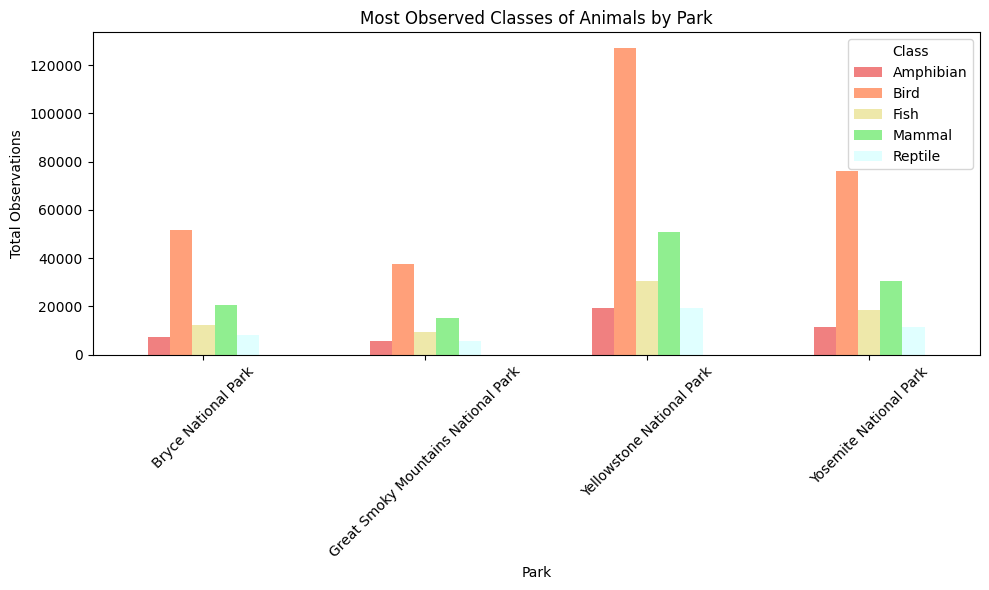

In [18]:
filtered_df = df[~df['category'].isin(['Vascular Plant', 'Nonvascular Plant'])] # filtering out plants as they dominate the dataset
grouped = filtered_df.groupby(['park_name', 'category'])['observations'].sum().reset_index() # grouping by park
pivot_table = grouped.pivot(index='park_name', columns='category', values='observations') 
pivot_table.plot(kind='bar', figsize=(10, 6), color=colours)
plt.xlabel('Park')
plt.ylabel('Total Observations')
plt.title('Most Observed Classes of Animals by Park')
plt.xticks(rotation=45)
plt.legend(title='Class')
plt.tight_layout()
plt.show()

The above grouped bar chart shows that birds were the most observed category of animal at every park, in fact each park has the same distribution of categories suggesting this may be down to how the data was recorded. 

Are the least observed species also the most endangered?

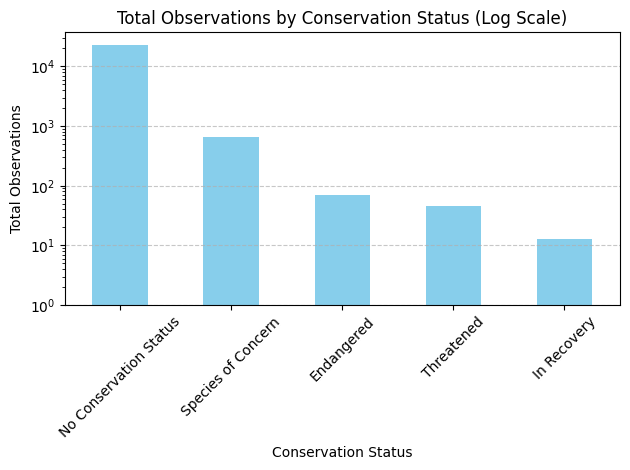

In [35]:
status_counts = df['conservation_status'].value_counts() # plants now included
status_counts.plot(kind='bar', log=True, color='skyblue')
plt.title('Total Observations by Conservation Status (Log Scale)')
plt.xlabel('Conservation Status')
plt.ylabel('Total Observations')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

The least observed species are the most endangered as expected given that population size is a key factor in determining conservation status. 

Species with no conservation status are significantly more observed. This is distorted by the log scale however the log scale allows us to see all conservation statuses on one graph.

Which types of animals are the most endangered?

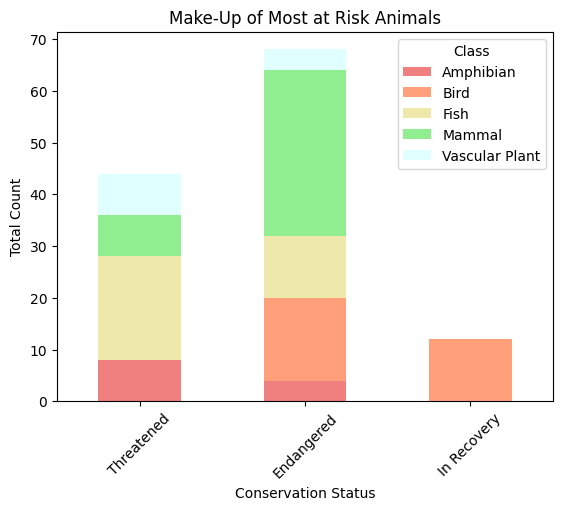

In [40]:
most_at_risk = df[
    (df['conservation_status'] != 'No Conservation Status') &
    (df['conservation_status'] != 'Species of Concern')
]

# Use crosstab to count rows
at_risk_count = pd.crosstab(
    index=most_at_risk['conservation_status'],
    columns=most_at_risk['category']
)
at_risk_count.plot(kind='bar', stacked=True, color=colours)
plt.xticks(rotation=45)
plt.legend(title='Class')
plt.xlabel('Conservation Status')
plt.ylabel('Total Count')
plt.title('Make-Up of Most at Risk Animals')
plt.show()

The above stacked bar chart shows that whilst many bird species are in recovery, more are endangered. We also note that non-vascular plants and reptiles are not represented at all in the most at-risk groups.

Which species were most observed across all 4 parks?

Wordcloud of Most Observed Species


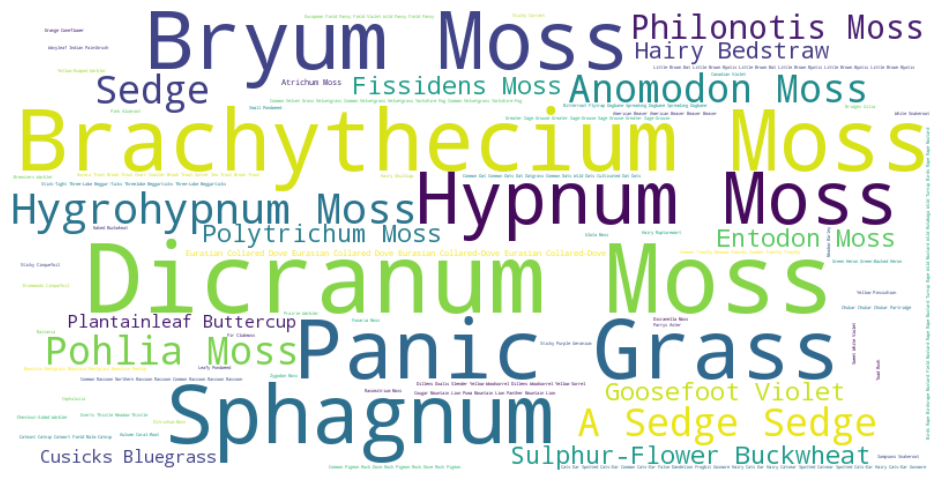

In [21]:
print('Wordcloud of Most Observed Species')
from wordcloud import WordCloud

df['common_names_cleaned'] = (
    df['common_names']
    .astype(str)
    .str.replace(r"[^\w\s\-]", "", regex=True)   # Remove punctuation except hyphens
    .str.replace(r"\s+", " ", regex=True)        # Normalise whitespace
    .str.strip()                                 # Remove leading/trailing spaces
)

species_counts = df.groupby('common_names_cleaned')['observations'].sum()
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(species_counts)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The above WordCloud is dominated by types of moss and grass showing that you're most likely to observe moss and grass at any of the 4 national parks.

Which animal species are most likely to be observed at each park?

In [42]:
top_animals = (
    filtered_df.groupby(['park_name', 'common_names'])['observations']
    .sum()
    .reset_index()
)

top_animals['common_names'] = top_animals['common_names'].str.split(',').str[0].str.strip()

top_animal_per_park = (
    top_animals.sort_values(['park_name', 'observations'], ascending=[True, False])
    .groupby('park_name', as_index=False)
    .first()
)

top_animal_per_park = top_animal_per_park.rename(columns={
    'common_names': 'top_animal',
    'observations': 'count'
})

print(top_animal_per_park.to_string(index=False))

                          park_name             top_animal  count
                Bryce National Park          Common Pigeon    339
Great Smoky Mountains National Park Eurasian Collared Dove    256
          Yellowstone National Park Eurasian Collared Dove    771
             Yosemite National Park        American Beaver    501


Which animal species are rarest at each park?

In [45]:
rarest_animals = (
    filtered_df.groupby(['park_name', 'common_names'])['observations']
    .sum()
    .reset_index()
)

rarest_animals['common_names'] = rarest_animals['common_names'].str.split(',').str[0].str.strip()

rarest_animal_per_park = (
    rarest_animals.sort_values(['park_name', 'observations'], ascending=[True, True])
    .groupby('park_name', as_index=False)
    .first()
)

rarest_animal_per_park = rarest_animal_per_park.rename(columns={
    'common_names': 'rarest_animal',
    'observations': 'count'
})

print(rarest_animal_per_park.to_string(index=False))

                          park_name                    rarest_animal  count
                Bryce National Park                Bachman's Warbler     20
Great Smoky Mountains National Park Sierra Nevada Yellow-Legged Frog     11
          Yellowstone National Park                   Whooping Crane     57
             Yosemite National Park                     Smoky Madtom     31


## Conclusion
This analysis explored trends in species observations across 4 national parks, with a focus on conservation status. We have answered the following research questions: 

What is the distribution of conservation statuses? <br>
The vast majority of species in this dataset have no conservation status, followed by animals registered as species of concern. The least represented group is species in recovery, which is approximately a fifth of the size of the endangered species group.

Are certain types of species more likely to be endangered? <br>
Yes, mammals are more likely to be endangered than other species, with reptiles the least likely to be endangered. Birds are the most observed category of animal and the second most likely to be endangered. 

Which species were spotted the most at each park? <br>
Mosses and grasses were spotted the most at each park, followed by the common pigeon and dove. Yosemite National Park was the exception to this trend where beavers are the most observed.

## Evaluation

Some entries had duplicate conservation statuses or species names, which were cleaned, but may still introduce bias. Observational counts depend on human reporting, which can introduce error and bias. Further research could investigate seasonal trends or explore whether conservation status impacts long-term population changes. Parks with very low species counts may benefit from increased monitoring or awareness campaigns. 